# Optimal Public Expenditure

This notebook computes the optimal level of public expenditure in a simple matching model of the business cycle.

The model features self-employed workers who sell their services on a matching market to other households and the government.

For all derivations, see section 2.2, section 2.4, section 5, and online appendix A in [Michaillat & Saez (Review of Economic Studies, 2019)](https://doi.org/10.1093/restud/rdy030)

In [68]:
# %load setup.py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Simulations 

We want to use the following parameters in our simulation:
1. $\epsilon$ : elasticity of substitution between public and private consumption
1. $\eta$ : matching elasticity
1.  $s$ : job-separation rate
1.  $\omega$ : matching efficiency
1. $\bar{u}$ : target for average unemployment
1. $\bar{x}$ : target for average tightness
1. $\bar{M}$ : target for average output multiplier (same as unemployment multiplier)
1. $\bar{G/C}$ : target for average G/C
1. $\bar{Y}$ : target for average output
1. $\gamma$ : preference parameter
1. $k$ : productive capacity, which can also be endogenized by adding a labor market where firms hire workers

Under the `Calibration` section of `optimal-stimulus.ipynb`, we already calibrated parameters $1-8$. We run `optimal-stimulus.ipynb` below to get all calibrated values based on US data between 2001 and 2019:

In [69]:
%%capture
%run optimal-stimulus.ipynb

Alternatively, you can uncomment the following code block and set the parameters manually. 

In [70]:
'''
epsilon = 1 
eta = 0.6
s = 0.028 
omega = 0.60 
u_bar = 0.061
x_bar = 0.43
M_bar = 0.5 
GC_bar = 0.197 
'''

'\nepsilon = 1 \neta = 0.6\ns = 0.028 \nomega = 0.60 \nu_bar = 0.061\nx_bar = 0.43\nM_bar = 0.5 \nGC_bar = 0.197 \n'

In [71]:
M_bar = 0.5

We now calibrate parameters $9-11$:

In [72]:
k = 1 # normalization
Y_bar = k*(1 - u_bar)
gamma = 1/(1 + 1/GC_bar) 

For convenience, we will define a few functions to calculate key macroeconomic variables:

In [73]:
GY = lambda gc:gc/(1 + gc) # G/Y
CY = lambda gc:1 - GY(gc)  # C/Y
GC = lambda GY:GY/(1 - GY) # G/C
u = lambda x:s/(s + f(x))  # unemployment rate
Y = lambda x:(1 - u(x))*k  # output

We will then use these functions to calculate target macroeconomic variables as well as the price rigidity $r$ that matches multiplier target :

In [74]:
GY_bar = GY(GC_bar)
CY_bar = CY(GC_bar)
G_bar = GY_bar*Y_bar
C_bar = CY_bar*Y_bar
r = (M_bar*epsilon*CY_bar)/(1 - M_bar*GY_bar)

We also compute the following matching parameters. 

The buying rate $q$, as a function of labor market tightness $x$, is:

$$q(x) = \omega x^{\eta}.$$

The selling rate $f$, as a function of labor market tightness $x$, is:

$$f(x) = \omega x^{1-\eta}.$$

In [75]:
q = lambda x:omega*x**(-eta) #buying rate
f = lambda x:omega*x**(1 - eta) #selling rate

The average matching wedge $\bar{\tau}$ is:

$$\bar{\tau} = (1-\eta)\frac{\bar{u}}{\eta}.$$

The matching cost $\rho$ is given by:

$$\rho = q(\bar{x})\frac{\bar{\tau}}{1+\bar{\tau}}.$$

The matching wedge $\tau$ is:

$$\tau(x) = s\frac{\rho}{q(x) - s\rho}.$$

The formula for elasticity of output to tightness is given by 

$$\frac{d\ln{y}}{d\ln{x}} = (1-\eta) * u(x) - \eta * \tau(x).$$

In [76]:
tau_bar = (1 - eta)*u_bar/eta #average matching wedge
rho = q(x_bar)/s*tau_bar/(1 + tau_bar) #matching cost
tau = lambda x:s*rho/(q(x) - s*rho) #matching wedge
dlnydlnx = lambda x:(1-eta)*u(x) - eta*tau(x) #elasticity of output to tightness

### Utility Function

Given the elasticity of substitution between private and public consumption $\epsilon$, we have the following CES utility function:

When $\epsilon = 1$, the utility function is Cobb-Douglas:

$$\mathcal{U}(c,g) = \frac{c^{1-\gamma}*g^{\gamma}}{(1-\gamma)^{1-\gamma}*\gamma^\gamma}$$

Otherwise, the utility function is:

$$\mathcal{U}(c, g) = \left((1-\gamma)^{1/\epsilon}*c^{(\epsilon-1)/\epsilon} + \gamma ^{1/\epsilon}*g^{(\epsilon - 1)/\epsilon}\right)^{\epsilon/(\epsilon - 1)}$$


In [77]:
if epsilon == 1:
    scalar = (1 - gamma)**(1 - gamma)*gamma**gamma
    U = lambda c, g:c**(1 - gamma)*g**(gamma)/scalar
else:
    U = lambda c, g:((1 - gamma)**(1/epsilon)*c**((epsilon - 1)/epsilon) + 
                     gamma**(1/epsilon)*g**((epsilon - 1)/epsilon))**(epsilon/(epsilon - 1))

With the given utility function, we have the following first derivatives:

$$\frac{\delta \ln{\mathcal{U}}}{\delta \ln{c}} = (1-\gamma)^{{1/\epsilon}} \left(\frac{c}{\mathcal{U}}\right)^{\frac{\epsilon-1}{\epsilon}},\quad \mathcal{U}_c \equiv \frac{\delta \mathcal{U}}{\delta c} = \left((1-\gamma) \frac{\mathcal{U}}{c}\right)^{1/\epsilon}$$

$$\frac{\delta \ln{\mathcal{U}}}{\delta \ln{g}} = \gamma^{{1/\epsilon}} \left(\frac{g}{\mathcal{U}}\right)^{\frac{\epsilon-1}{\epsilon}},\quad \mathcal{U}_g \equiv \frac{\delta \mathcal{U}}{\delta g} = \left(\gamma \frac{\mathcal{U}}{g}\right)^{1/\epsilon}$$


which gives the marginal rate of substitution:

$$MRS_{gc} = \frac{\mathcal{U}_g}{\mathcal{U}_c}  = \frac{\gamma^{1/\epsilon}}{(1-\gamma)^{1/\epsilon}}*(gc)^{1/\epsilon}.$$

We also have the following second derivatives:

$$
\frac{\delta \ln{\mathcal{U}_c}}{\delta \ln{c}} = \frac{1}{\epsilon}\left(\frac{\delta \mathcal{U}}{\delta c} -1 \right),$$
$$\frac{\delta \ln{\mathcal{U}_c}}{\delta \ln{g}} = \frac{1}{\epsilon}\left(\frac{\delta \mathcal{U}}{\delta g} \right)
$$


In [78]:
dUdc = lambda gc:((1-gamma)*U(1,gc))**(1/epsilon)
dUdc_bar = dUdc(GC_bar)
dUdg = lambda gc:(gamma*U(1/gc, 1))**(1/epsilon)
MRS = lambda gc:gamma**(1/epsilon)/(1-gamma)**(1/epsilon)*gc**(1/epsilon)
dlnUdlnc = lambda gc:(1 - gamma)**(1/epsilon)*(U(1, gc))**((1 - epsilon)/epsilon)
dlnUdlng = lambda gc:gamma**(1/epsilon)*(U(1/gc, 1))**((1 - epsilon)/epsilon)
dlnUcdlnc = lambda gc:(dlnUdlnc(gc) - 1)/epsilon
dlnUcdlng = lambda gc:dlnUdlng(gc)/epsilon

### Unemployment Multipliers

Then, we move on to compute the theoretical unemployment multiplier and the output multiplier. The full derivation can be found in `online appendix A`. 

First, we want to compute the effect of public consumption on the price of services, which requires us to look at the price mechanism. It is rigid since it does not respond to demand shocks, and is an expression for the multiplier:

$$p(G) = p_0 \left\{ (1-\gamma) + \gamma ^{\frac{1}{\epsilon}}\left[(1-\gamma)\frac{g}{y^*-g}\right]^{\frac{\epsilon-1}{\epsilon}}\right \}^\frac{1-r}{\epsilon - 1},$$

which gives us:

$$\frac{d\ln{p}}{d\ln{g}} = (1-r) \left[ \frac{\delta\ln{\mathcal{U}_c}}{\delta \ln{g}} - \frac{G}{y^* - G} \frac{\delta\ln{\mathcal{U}_c}}{\delta \ln{c}}  \right] $$

In [79]:
# initial price level
p0 = dUdc_bar**r/(1 + tau_bar) 
p = lambda G:p0*dUdc(G/(Y_bar-G))**(1 - r)
dlnpdlng = lambda G:(1 - r)*(dlnUcdlng(G/(Y_bar - G)) - dlnUcdlnc(G/(Y_bar - G))*(G/(Y_bar - G)))

Then we want to compute the effects of public consumption and tightness on private demand, which are:

$$
\frac{\delta\ln{c}}{\delta \ln{x}} = \frac{\eta \tau(x)}{\delta \ln{\mathcal{U}_c}/\delta\ln(c)}$$
$$\frac{\delta\ln{g}}{\delta \ln{x}} = \frac{\delta \ln{p}/\delta\ln(g) - \delta \ln{\mathcal{U}_c}/\delta\ln(g)}{\delta \ln{\mathcal{U}_c}/\delta\ln(c)}$$

In [80]:
dlncdlnx = lambda G, x:eta*tau(x)/dlnUcdlnc(G/(Y(x)-G))
dlncdlng = lambda G, x:(dlnpdlng(G)-dlnUcdlng(G/(Y(x)-G)))/dlnUcdlnc(G/(Y(x)-G))

We can also determine the effect of public consumption on equilibrium tightness, which is:

$$\frac{\delta\ln{x}}{\delta \ln{g}} = \frac{(g/y) + (c/y)\delta\ln{c}/\delta\ln{g}}{\delta\ln{y}/\delta\ln{x} - (c/y)\delta\ln{c}/\delta\ln{x}}$$

In [81]:
# Remember to call code library

dlnxdlng = lambda G, x:(G/Y(x) + (1 - G/Y(x))*dlncdlng(G, x))/(dlnydlnx(x) - (1-G/Y(x))*dlncdlnx(G, x))

Thus, we can compute the theoretical unemployment multiplier

$$m = (1-\eta) (1-u) u \frac{y}{g}\frac{d\ln{x}}{d\ln{g}},$$

and the empirical unemployment multiplier

$$M = \frac{m}{1- u + \frac{g}{y}\frac{\eta}{1-\eta}\frac{\tau}{u}m}.$$

In [82]:
m = lambda G, x:(1 - eta)*u(x)*(1 - u(x))*dlnxdlng(G, x)*Y(x)/G 
M = lambda G, x:m(G, x)/(1 - u(x) + G/Y(x)*eta*tau(x)/(1 - eta)/u(x)*m(G, x))

### Simulations

We will now run simulations under different shocks. To determine equilibrium under different aggregate demand/government spending, we need to find where AD and AS intersect, which happens when 

$$\frac{dU}{dc} - G = (1+\tau)\frac{p(G)}{\alpha}$$

In [83]:
# gap between aggregate supply & aggregate demand
findeq = lambda G, x, alpha:abs(dUdc(G/(Y(x) - G)) - ((1 + tau(x))*p(G)/alpha))

We will now run business cycle simulations under aggregate demand shocks, fixing the public expenditure policy at $G/Y = 16.5\%$. For each magnitude of aggregate demand, we find the equilibrium labor market tightness using grid search. 

In [84]:
# Range of aggregate demand
ALPHA = np.arange(start=0.97, step=0.0025, stop=1.03) 
# Grid to search for equilibrium tightness x
x0 = np.arange(start=0.001, step=0.0002, stop=2) 
xad, Gad = np.empty(len(ALPHA)), np.empty(len(ALPHA))
G0 = GY_bar*Y(x0)	# G such that G/Y=16.5%
for i, alpha in enumerate(ALPHA):
    eva = findeq(G0, x0, alpha)
    # Finding where AS = AD
    ind = np.argmin(eva)
    # Record equlibrium tightness and public expenditure
    xad[i] = x0[ind]
    Gad[i] = G0[ind]

We then compute all other equilibrium variables with $G/Y = 16.5\%$ under the aggregate demand shocks. 

In [85]:
Yad = Y(xad) # output
GYad = Gad/Yad # G/Y
uad = u(xad) # unemployment rate
Mad = M(Gad, xad) # output multiplier

We then run business-cycle simulations under public spending shocks. We compute equilibrium variables for a range of public spending to output ratios $G/Y$.

In [86]:
# Range of public expenditure G/Y
GY0 = np.arange(start=0.1, step=0.00005, stop=0.25) 
xgy, Ggy = np.empty(len(GY0)), np.empty(len(GY0))
for i, gy in enumerate(GY0):
    # Find G such that G/Y=gy
    G0 = gy*Y(x0)
    eva = findeq(G0, x0, 1)
    ind = np.argmin(eva)
    # Record equlibrium tightness and public expenditure
    xgy[i]=x0[ind]
    Ggy[i]=G0[ind]

And we compute all other macro variables of interest:

In [87]:
Ygy = Y(xgy)      # output
GYgy = Ggy/Ygy    # G/Y
ugy = u(xgy)      # unemployment rate
Mgy = M(Ggy, xgy) # output multiplier

Let's first look at equilibria under aggregate demand shocks:

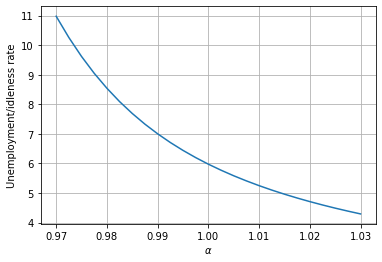

In [88]:
# Unemployment
fig, ax = plt.subplots()
ax.plot(ALPHA, uad*100)
ax.set(xlabel=r'$\alpha$', ylabel='Unemployment/idleness rate')
ax.grid()
plt.show()

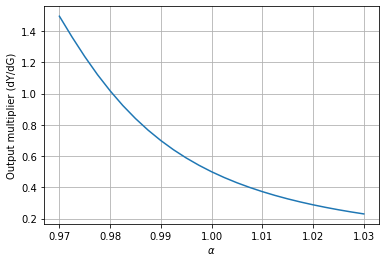

In [89]:
# Output multiplier
fig, ax = plt.subplots()
ax.plot(ALPHA, Mad)
ax.set(xlabel=r'$\alpha$', ylabel='Output multiplier (dY/dG)')
ax.grid()
plt.show()

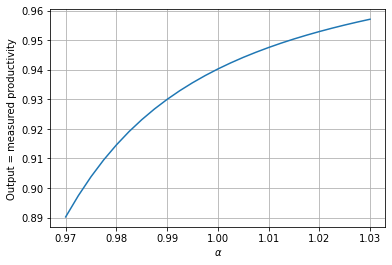

In [90]:
# Output 
fig, ax = plt.subplots()
ax.plot(ALPHA, Yad)
ax.set(xlabel=r'$\alpha$', ylabel='Output = measured productivity')
ax.grid()
plt.show()

We will then examine equilibria under different government spending:

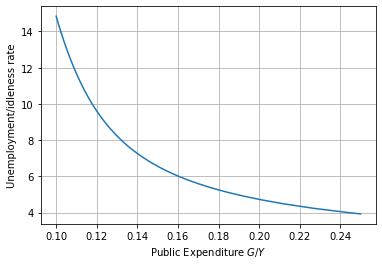

In [91]:
# Unemployment Rate
fig, ax = plt.subplots()
ax.plot(GY0, ugy*100)
ax.set(xlabel=r'Public Expenditure $G/Y$', ylabel='Unemployment/idleness rate')
ax.grid()
plt.show()

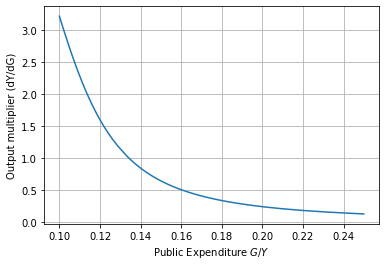

In [92]:
# Output Multiplier
fig, ax = plt.subplots()
ax.plot(GY0, Mgy)
ax.set(xlabel=r'Public Expenditure $G/Y$', ylabel='Output multiplier (dY/dG)')
ax.grid()
plt.show()

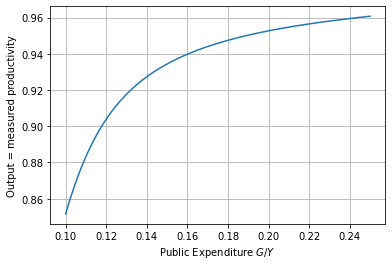

In [93]:
# Unemployment Rate
fig, ax = plt.subplots()
ax.plot(GY0, Ygy)
ax.set(xlabel=r'Public Expenditure $G/Y$', ylabel='Output = measured productivity')
ax.grid()
plt.show()